<a href="https://colab.research.google.com/github/BLayus/Sales-Prediction/blob/main/Rossmann_Store_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importando Bibliotecas e Datasets

In [1]:
!pip install inflection

# Biblioteca para trabalhar com strings, renomear colunas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Imports

import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import inflection
import math

import calendar

from datetime import datetime


In [3]:
# Dataset

from google.colab import drive
drive.mount('/content/drive')

df_sales = pd.read_csv('/content/drive/MyDrive/Data Science /Comunidade DS/DS em Produção Rossmann/Dataset/train.csv', low_memory= False)

df_store = pd.read_csv('/content/drive/MyDrive/Data Science /Comunidade DS/DS em Produção Rossmann/Dataset/store.csv', low_memory= False)

Mounted at /content/drive


In [4]:
df_sales.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
# Observa-se a necessidade de unir as duas tabelas. A primeira mostra as vendas por data de cada loja e a segunda mostra todas as lojas com outros atributos.
# A coluna store será usada para juntar as tabelas e o nível de granularidsade será o da tabela sales

In [7]:
# Merge (Join) entre os datasets

df_raw = pd.merge(df_sales, df_store, how='left', on= 'Store')

In [8]:
# As tabelas foram mergeadas com sucesso

df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
796136,812,4,2013-07-18,6858,878,1,1,0,1,d,a,2590.0,9.0,2012.0,0,NaN,NaN,NaN


### Descrição dos Dados

In [9]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
df_raw.shape

# São aprox 1 milhão de linhas com 18 colunas, um dataset médio/grande

(1017209, 18)

In [11]:
# Fazendo uma cópia do df_raw

df1 = df_raw.copy()

# Criando uma lista com nomes de colunas antes do rename

cols_old = df1.columns

# Criando uma função para renomear as colunas

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map(snakecase, cols_old))

df1.columns = cols_new

print(df1.columns)

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')


In [12]:
# Mostrando shape, número de linhas e colunas

print(f'Número de Linhas: {df1.shape[0]}')
print(f'Número de Colunas: {df1.shape[1]}')

Número de Linhas: 1017209
Número de Colunas: 18


In [13]:
# Mostrando os data types

df1.dtypes


store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [14]:
# vamos precisar converter alguns tipos de dados para os formatos corretos
# date está como object e tem que ser datetime

df1['date'] = pd.to_datetime(df1['date'])

In [15]:
# Avaliando as colunas que possuem linhas com dados faltantes

df1.isna().sum()


store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [16]:
# Substituindo dados faltantes

# competition_distance (distância em metros de uma loja concorrente)
# Hipótese: não há nenhuma loja concorrente nas proximidades, assumir que a loja concorrente mais próxima está tão distante que não representa concorrência

df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000 if math.isnan(x) else x )

# competition_open_since_month
# Hipótese: Não tem concorrente próximo, não sabemos quando a loja foi aberta. Assumir a data de venda como data da loja concorrente aberta

df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year

df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_month'], axis=1)

# promo2_since_week
# loja decidiu não participar da promoção, valor promo2 = 0

df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
# Mesma hipótese da promo2_since_week

df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
# Hipótese: crtiar uma nova coluna onde 0 significa que a loja não continuou a promo2 e 1 significa que a loja continuou a promo2

month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12:'Dec'}

df1['promo_interval']. fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply (lambda x: 0 if x['promo_interval'] == 0
                                                              else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                              else 0, axis=1)


In [17]:
df1.sample(5).T

,704490,442804,920507,833664,70514
store,596,935,303,430,270
day_of_week,2,6,4,5,5
date,2013-10-08 00:00:00,2014-05-31 00:00:00,2013-03-28 00:00:00,2013-06-14 00:00:00,2015-05-29 00:00:00
sales,5597,3611,8211,7437,10012
customers,817,383,910,668,1325
open,1,1,1,1,1
promo,1,0,1,0,0
state_holiday,0,0,0,0,0
school_holiday,1,0,1,0,0
store_type,c,a,a,d,a


<Axes: >

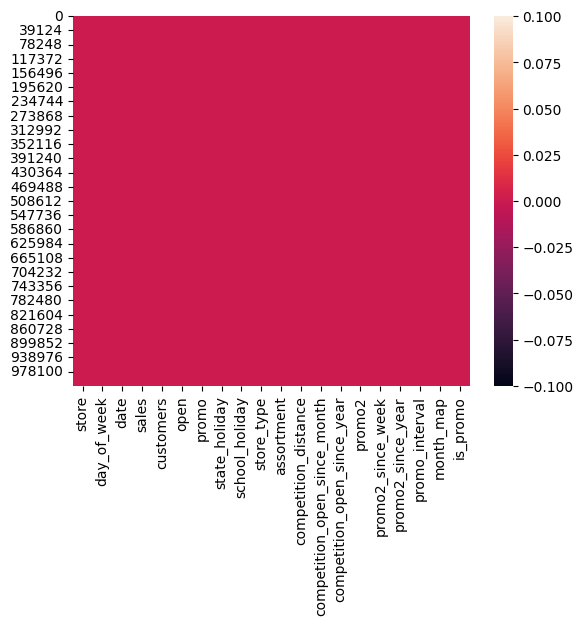

In [18]:
# Avaliando quantos NaN ficaram no dataset através de um heatmap, um mapa das posições nulas no dataset


sns.heatmap(df1.isnull(), cbar=True)

In [19]:
# Verificando nulos com valores totais
df1.isna().sum()


store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [20]:
# Verificando nulos com valores percentuais
df1.isna().sum() / df1.shape[0] * 100

store                           0.0
day_of_week                     0.0
date                            0.0
sales                           0.0
customers                       0.0
open                            0.0
promo                           0.0
state_holiday                   0.0
school_holiday                  0.0
store_type                      0.0
assortment                      0.0
competition_distance            0.0
competition_open_since_month    0.0
competition_open_since_year     0.0
promo2                          0.0
promo2_since_week               0.0
promo2_since_year               0.0
promo_interval                  0.0
month_map                       0.0
is_promo                        0.0
dtype: float64

In [21]:
# Acertando tipos de dados

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [23]:
# Alterando tipos de dados de algumas colunas que aparecem como float e podem ser int

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

### Estatistica Descritiva

In [20]:
# Medidas de tendência central, média, mediana, etc
# Medidas de dispersão, como desvio padrão, variância, distribuição, etc


In [25]:
# Separando as variáveis numéricas das variáveis categóricas

num_variables = df1.select_dtypes(include= ['int64', 'float64'])
cat_variables = df1.select_dtypes(exclude= ['int64', 'float64', 'datetime64[ns]'])

In [32]:
# Mostrando médias e medianas das variáveis numéricas

ct_num_mean = pd.DataFrame(num_variables.apply (np.mean)).T
ct_num_median = pd.DataFrame(num_variables.apply (np.median)).T


In [37]:
# Medidas de dispersão

disp_std = pd.DataFrame(num_variables.apply(np.std)).T
disp_min = pd.DataFrame(num_variables.apply(min)).T
disp_max = pd.DataFrame(num_variables.apply(max)).T
disp_range = pd.DataFrame(num_variables.apply(lambda x: x.max() - x.min())).T
disp_skew = pd.DataFrame(num_variables.apply(lambda x: x.skew())).T
disp_kurtosis = pd.DataFrame(num_variables.apply(lambda x: x.kurtosis())).T

In [39]:
# Concatenando todas as métricas em uma só tabela

metrics = pd.concat([disp_min, disp_max, disp_range, ct_num_mean, ct_num_median, disp_std, disp_skew, disp_kurtosis]).T.reset_index()

metrics.columns= ['Atributos', 'Min', 'Max', 'Range', 'Média', 'Mediana', 'Desvio Padrão', 'Skewness', 'Kurtosis']

metrics

,Atributos,Min,Max,Range,Média,Mediana,Desvio Padrão,Skewness,Kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1.0,2015.0,2014.0,645.079207,10.0,934.384928,0.782202,-1.388125


In [42]:
# Podemos usar a função describe pra avaliar várias métricas padrão de uma só vez

num_variables.describe().round(1)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
count,1017209.0,1017209.0,1017209.0,1017209.0,1017209.0,1017209.0,1017209.0,1017209.0,1017209.0,1017209.0,1017209.0,1017209.0,1017209.0,1017209.0
mean,558.4,4.0,5773.8,633.1,0.8,0.4,0.2,5935.4,6.8,645.1,0.5,23.6,2012.8,0.2
std,321.9,2.0,3849.9,464.4,0.4,0.5,0.4,12547.7,3.3,934.4,0.5,14.3,1.7,0.4
min,1.0,1.0,0.0,0.0,0.0,0.0,0.0,20.0,1.0,1.0,0.0,1.0,2009.0,0.0
25%,280.0,2.0,3727.0,405.0,1.0,0.0,0.0,710.0,4.0,6.0,0.0,12.0,2012.0,0.0
50%,558.0,4.0,5744.0,609.0,1.0,0.0,0.0,2330.0,7.0,10.0,1.0,22.0,2013.0,0.0
75%,838.0,6.0,7856.0,837.0,1.0,1.0,0.0,6910.0,10.0,2013.0,1.0,37.0,2014.0,0.0
max,1115.0,7.0,41551.0,7388.0,1.0,1.0,1.0,200000.0,12.0,2015.0,1.0,52.0,2015.0,1.0


In [43]:
cat_variables.describe().round(1)

,state_holiday,store_type,assortment,promo_interval,month_map
count,1017209,1017209,1017209,1017209,1017209
unique,4,4,3,4,12
top,0,a,a,0,May
freq,986159,551627,537445,508031,103695
